## Imports

In [1]:
from datetime import datetime
import numpy as np
import pickle
import json
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/MyDrive/SPARSe

/content/gdrive/.shortcut-targets-by-id/1hNRRb9O7Y1kI_ulnKgi3KeD8eRwFsiwr/SPARSe


In [4]:
data = pd.read_csv("features_labels/Model_Features_v1.csv")
labels = pd.read_csv("features_labels/Model_Labels_Binary_v0.csv")

In [5]:
data = data.merge(labels, on="projectid")
data.drop(["Unnamed: 0_y", "Unnamed: 0_x"], axis = 1, inplace = True)

In [6]:
data

,projectid,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,total_price_excluding_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,school_state_AK,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,school_state_DC,school_state_DE,school_state_FL,school_state_GA,school_state_HI,school_state_IA,school_state_ID,school_state_IL,school_state_IN,school_state_KS,school_state_KY,school_state_LA,school_state_MA,school_state_MD,school_state_ME,school_state_MI,school_state_MN,school_state_MO,school_state_MS,school_state_MT,school_state_NC,school_state_ND,school_state_NE,school_state_NH,school_state_NJ,school_state_NM,school_state_NV,school_state_NY,school_state_OH,school_state_OK,school_state_OR,school_state_PA,school_state_RI,school_state_SC,school_state_SD,school_state_TN,school_state_TX,school_state_UT,school_state_VA,school_state_VT,school_state_WA,school_state_WI,school_state_WV,school_state_WY,school_metro_missing,school_metro_rural,school_metro_suburban,school_metro_urban,teacher_prefix_Dr.,teacher_prefix_Mr.,teacher_prefix_Mr. & Mrs.,teacher_prefix_Mrs.,teacher_prefix_Ms.,teacher_prefix_missing,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,primary_focus_area_missing,secondary_focus_area_Applied Learning,secondary_focus_area_Health & Sports,secondary_focus_area_History & Civics,secondary_focus_area_Literacy & Language,secondary_focus_area_Math & Science,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,secondary_focus_area_missing,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,resource_type_missing,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,grade_level_missing,total_number_of_donations,total_value_of_donations,num_promo_matched,prop_of_donations_from_same_city,prop_of_donations_from_same_state,prop_of_teacher_donors,prop_via_giving_page,avg_value_per_donation,total_prop_funded,prop_promo_matched,num_words_in_title,num_words_in_short_description,num_words_in_essay,is_fully_funded
0,316ed8fb3b81402ff6ac8f721bb31192,0,0,0,0,0,0,0,0,555.81,32.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3,39,396,0
1,90de744e368a7e4883223ca49318ae30,0,0,0,0,0,0,0,0,296.47,22.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,7,36,218,0
2,32943bb1063267de6ed19fc0ceb4b9a7,0,0,0,0,0,0,0,0,430.89,17.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,7,42,237,0
3,bb18f409abda2f264d5acda8cab577a9,0,1,0,0,0,0,1,0,576.07,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,7,32,285,0
4,24761b686e18e5eace634607acbcc19f,0,0,0,0,0,0,0,0,408.40,24.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0

In [7]:
train_test_val_project_ids = json.load(open('trainvalsplit50.json', 'r'))

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Neural Net
hidden_layers = [1, 2, 3, 5]
hidden_layer_sizes = [16, 32, 64]
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
for num_layers in hidden_layers:
  for layer_size in hidden_layer_sizes:
    for lr in learning_rates:
      train_ids = train_test_val_project_ids[f"train{30}"]
      valid_ids = train_test_val_project_ids[f"valid{30}"]
      train_data = data[data.projectid.isin(train_ids)]
      val_data = data[data.projectid.isin(valid_ids)]
      train_labels = train_data["is_fully_funded"].to_numpy()
      train_features = train_data.drop(["is_fully_funded", "projectid"], axis = 1).to_numpy()

      test_labels = val_data["is_fully_funded"].to_numpy()
      test_features = val_data.drop(["is_fully_funded", "projectid"], axis = 1).to_numpy()
      classifier = MLPClassifier(hidden_layer_sizes = [layer_size]*num_layers, activation = "relu", solver = "adam", learning_rate_init = lr)
      classifier = classifier.fit(train_features, train_labels)
      results = np.concatenate([classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
      results = results[results[:, 1].argsort()]
      print(f"num layers: {num_layers}, layer size: {layer_size}, lr: {lr}")
      print((np.mean((results[:results.shape[0]//10, 1] > 0.5) == (results[:results.shape[0]//10, 2] > 0.5))))

#3 layers, size 32, lr 1e-4

In [15]:
#Random Forest
max_depths = [2, 3, 4, 5, 6]
tree_nums = [80, 160, 320, 640]
for max_depth in max_depths:
  for tree_num in tree_nums:
    train_ids = train_test_val_project_ids[f"train{30}"]
    valid_ids = train_test_val_project_ids[f"valid{30}"]
    train_data = data[data.projectid.isin(train_ids)]
    val_data = data[data.projectid.isin(valid_ids)]
    train_labels = train_data["is_fully_funded"].to_numpy()
    train_features = train_data.drop(["is_fully_funded", "projectid"], axis = 1).to_numpy()

    test_labels = val_data["is_fully_funded"].to_numpy()
    test_features = val_data.drop(["is_fully_funded", "projectid"], axis = 1).to_numpy()
    classifier = RandomForestClassifier(n_estimators = tree_num, max_depth = max_depth)
    classifier = classifier.fit(train_features, train_labels)
    results = np.concatenate([classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
    results = results[results[:, 1].argsort()]
    print(f"max depth: {max_depth}, tree num: {tree_num}")
    print((np.mean((results[:results.shape[0]//10, 1] > 0.5) == (results[:results.shape[0]//10, 2] > 0.5))))
#best depth 3, 160 trees

max depth: 2, tree num: 80, lr: 0.1
0.823914823914824
max depth: 2, tree num: 160, lr: 0.1
0.8091728091728092
max depth: 2, tree num: 320, lr: 0.1
0.8181818181818182
max depth: 2, tree num: 640, lr: 0.1
0.8206388206388207
max depth: 3, tree num: 80, lr: 0.1
0.8018018018018018
max depth: 3, tree num: 160, lr: 0.1
0.8345618345618345
max depth: 3, tree num: 320, lr: 0.1
0.8230958230958231
max depth: 3, tree num: 640, lr: 0.1
0.8345618345618345
max depth: 4, tree num: 80, lr: 0.1
0.8230958230958231
max depth: 4, tree num: 160, lr: 0.1
0.8042588042588042
max depth: 4, tree num: 320, lr: 0.1
0.8091728091728092
max depth: 4, tree num: 640, lr: 0.1
0.8247338247338247
max depth: 5, tree num: 80, lr: 0.1
0.8304668304668305
max depth: 5, tree num: 160, lr: 0.1
0.8198198198198198
max depth: 5, tree num: 320, lr: 0.1
0.8312858312858313
max depth: 5, tree num: 640, lr: 0.1
0.8247338247338247
max depth: 6, tree num: 80, lr: 0.1
0.8288288288288288
max depth: 6, tree num: 160, lr: 0.1
0.816543816543816

In [22]:
#XGB
max_depths = [7, 8, 9]
etas = [0.1, 0.3]

for max_depth in max_depths:
  for eta in etas:
    train_ids = train_test_val_project_ids[f"train{30}"]
    valid_ids = train_test_val_project_ids[f"valid{30}"]
    train_data = data[data.projectid.isin(train_ids)]
    val_data = data[data.projectid.isin(valid_ids)]
    train_labels = train_data["is_fully_funded"].to_numpy()
    train_features = train_data.drop(["is_fully_funded", "projectid"], axis = 1).to_numpy()

    test_labels = val_data["is_fully_funded"].to_numpy()
    test_features = val_data.drop(["is_fully_funded", "projectid"], axis = 1).to_numpy()
    classifier = xgb.XGBClassifier(max_depth = max_depth, eta = eta, learning_rate = 1e-3)
    classifier = classifier.fit(train_features, train_labels)
    results = np.concatenate([classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
    results = results[results[:, 1].argsort()]
    print(f"max depth: {max_depth}, eta: {eta}")
    print((np.mean((results[:results.shape[0]//10, 1] > 0.5) == (results[:results.shape[0]//10, 2] > 0.5))))
#max depth 7, eta 0.3

max depth: 7, eta: 0.3
0.7805077805077805
max depth: 8, eta: 0.3
0.7772317772317773


KeyboardInterrupt: ignored

In [14]:
#Logistic Regression
cs = [0.1, 0.2, 0.5, 1, 2, 5]
for i in range(len(cs)):
  train_ids = train_test_val_project_ids[f"train{30}"]
  valid_ids = train_test_val_project_ids[f"valid{30}"]
  train_data = data[data.projectid.isin(train_ids)]
  val_data = data[data.projectid.isin(valid_ids)]
  train_labels = train_data["is_fully_funded"].to_numpy()
  train_features = train_data.drop(["is_fully_funded", "projectid"], axis = 1).to_numpy()

  test_labels = val_data["is_fully_funded"].to_numpy()
  test_features = val_data.drop(["is_fully_funded", "projectid"], axis = 1).to_numpy()
  classifier = LogisticRegression(solver='lbfgs', C = cs[i], max_iter=10000)
  classifier = classifier.fit(train_features, train_labels)
  results = np.concatenate([classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
  results = results[results[:, 1].argsort()]
  print((np.mean((results[:results.shape[0]//10, 1] > 0.5) == (results[:results.shape[0]//10, 2] > 0.5))))

0.7854217854217854
0.7886977886977887
0.7624897624897625


KeyboardInterrupt: ignored

In [32]:
from sklearn import neural_network
baseline_accs = []
logistic_regression_accs = []
decision_tree_accs = []
nn_accs = []
random_forest_accs = []
xgb_accs = []

time = []
for i in range(50):
  print(i)
  train_ids = train_test_val_project_ids[f"train{i+1}"]
  valid_ids = train_test_val_project_ids[f"valid{i+1}"]
  time.append(train_test_val_project_ids[f"train_end{i+1}"])
  train_data = data[data.projectid.isin(train_ids)]
  val_data = data[data.projectid.isin(valid_ids)]
  train_labels = train_data["is_fully_funded"].to_numpy()
  train_features = train_data.drop(["is_fully_funded", "projectid"], axis = 1).to_numpy()
  
  test_labels = val_data["is_fully_funded"].to_numpy()
  test_features = val_data.drop(["is_fully_funded", "projectid"], axis = 1).to_numpy()
  #Baseline Accs
  results = val_data[["total_prop_funded", "total_prop_funded", "is_fully_funded"]].to_numpy()
  results = results[results[:, 1].argsort()]
  baseline_accs.append(1-np.mean(results[:results.shape[0]//10, 2]))
  #Logistic Regression
  classifier = LogisticRegression(solver='lbfgs', max_iter=10000)
  classifier = classifier.fit(train_features, train_labels)
  results = np.concatenate([classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
  results = results[results[:, 1].argsort()]
  logistic_regression_accs.append((np.mean((results[:results.shape[0]//10, 1] > 0.5) == (results[:results.shape[0]//10, 2] > 0.5))))
  #Decision Tree
  classifier = DecisionTreeClassifier(max_depth=5)
  classifier = classifier.fit(train_features, train_labels)
  results = np.concatenate([classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
  results = results[results[:, 1].argsort()]
  decision_tree_accs.append((np.mean((results[:results.shape[0]//10, 1] > 0.5) == (results[:results.shape[0]//10, 2] > 0.5))))
  #Random Forest
  classifier = RandomForestClassifier(n_estimators = 160, max_depth = 3)
  classifier = classifier.fit(train_features, train_labels)
  results = np.concatenate([classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
  results = results[results[:, 1].argsort()]
  random_forest_accs.append((np.mean((results[:results.shape[0]//10, 1] > 0.5) == (results[:results.shape[0]//10, 2] > 0.5))))
  #Neural Net
  classifier = MLPClassifier(hidden_layer_sizes = [32]*3, activation = "relu", solver = "adam", learning_rate_init = 1e-4)
  classifier = classifier.fit(train_features, train_labels)
  results = np.concatenate([classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
  results = results[results[:, 1].argsort()]
  nn_accs.append((np.mean((results[:results.shape[0]//10, 1] > 0.5) == (results[:results.shape[0]//10, 2] > 0.5))))
  #XGB
  classifier = xgb.XGBClassifier(max_depth = 7, eta = 0.3, learning_rate = 1e-3)
  classifier = classifier.fit(train_features, train_labels)
  results = np.concatenate([classifier.predict_proba(test_features), test_labels[:, np.newaxis]], axis = 1)
  results = results[results[:, 1].argsort()]
  xgb_accs.append((np.mean((results[:results.shape[0]//10, 1] > 0.5) == (results[:results.shape[0]//10, 2] > 0.5))))

0
1


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3
4


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


6


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


7
8


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


9
10


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


11


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


12
13
14
15
16
17
18


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


19


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


20


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


21


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


38
39
40
41
42
43
44


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


45
46
47
48
49


In [33]:
baseline_baseline_accs = []
for i in range(50):
  valid_ids = train_test_val_project_ids[f"valid{i+1}"]
  val_data = data[data.projectid.isin(valid_ids)]
  baseline_baseline_accs.append(1-np.mean(val_data[["is_fully_funded"]].to_numpy()))

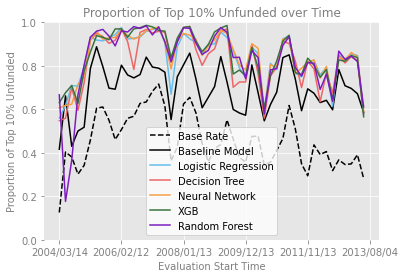

In [37]:
import matplotlib.pyplot as plt
ax = plt.axes(facecolor = "#E6E6E6")
plt.grid(color = "w", linestyle = "solid")
for spine in ax.spines.values():
  spine.set_visible(False)
ax.tick_params(colors = "gray", direction = "out")
ax.set_xticks(np.arange(0, 51, 10))
ax.set_xticklabels(time[::10] + [time[-1]])
ax.set_xlabel("Evaluation Start Time", color = "gray")
ax.set_ylabel("Proportion of Top 10% Unfunded", color = "gray")
ax.set_title("Proportion of Top 10% Unfunded over Time", color = "gray")
ax.plot([i for i in range(len(baseline_baseline_accs))], baseline_baseline_accs, "--", color = "#000000", label = "Base Rate")
ax.plot([i for i in range(len(baseline_baseline_accs))], baseline_accs, color = "#000000", label = "Baseline Model")
ax.plot([i for i in range(len(baseline_baseline_accs))], logistic_regression_accs, color = "#66BEEE", label = "Logistic Regression")
ax.plot([i for i in range(len(baseline_baseline_accs))], decision_tree_accs, color = "#EE6666", label = "Decision Tree")
ax.plot([i for i in range(len(baseline_baseline_accs))], nn_accs, color = "#f59e42", label = "Neural Network")
ax.plot([i for i in range(len(baseline_baseline_accs))], xgb_accs, color = "#39733c", label = "XGB")
ax.plot([i for i in range(len(baseline_baseline_accs))], random_forest_accs, color = "#7d1bbf", label = "Random Forest")
ax.legend()
ax.set_ylim([0, 1])
plt.show()

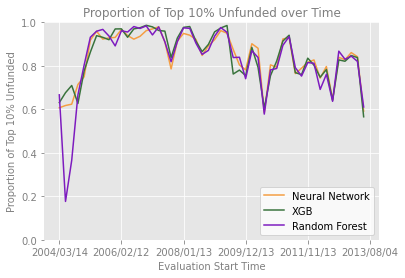

In [39]:
import matplotlib.pyplot as plt
ax = plt.axes(facecolor = "#E6E6E6")
plt.grid(color = "w", linestyle = "solid")
for spine in ax.spines.values():
  spine.set_visible(False)
ax.tick_params(colors = "gray", direction = "out")
ax.set_xticks(np.arange(0, 51, 10))
ax.set_xticklabels(time[::10] + [time[-1]])
ax.set_xlabel("Evaluation Start Time", color = "gray")
ax.set_ylabel("Proportion of Top 10% Unfunded", color = "gray")
ax.set_title("Proportion of Top 10% Unfunded over Time", color = "gray")
ax.plot([i for i in range(len(baseline_baseline_accs))], nn_accs, color = "#f59e42", label = "Neural Network")
ax.plot([i for i in range(len(baseline_baseline_accs))], xgb_accs, color = "#39733c", label = "XGB")
ax.plot([i for i in range(len(baseline_baseline_accs))], random_forest_accs, color = "#7d1bbf", label = "Random Forest")
ax.legend()
ax.set_ylim([0, 1])
plt.show()